# Driver Distraction Monitoring

Approximately 1.35 million people die every year as a result of road traffic crashes. Road traffic injuries are the leading cause of death for children and young adults aged 5 - 29 years. It cost most countries 30% of their Gross Domestic Product. Egypt for example loses about 12 thousands lives due to road traffic crashes every year which means more than 32 Egyption die everyday in a car carsh. By monitoring the driver and notifying him if he's distracted we can eliminate these numbers. 

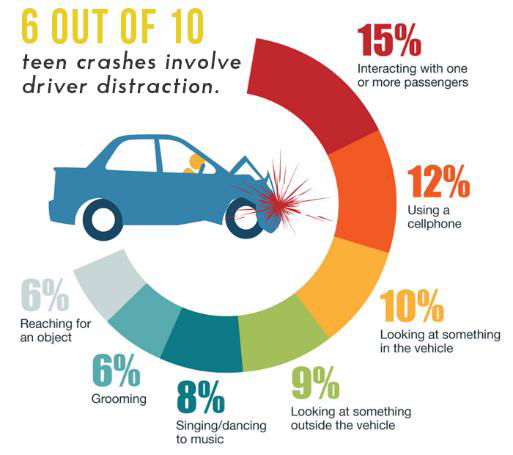

# Importing Dependencies

First we import the packages you'll need. It's good practice to keep all the imports at the beginning of your code.


In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
import PIL
from torch.optim import lr_scheduler
import copy
import json
import os
import sys
import shutil  
from torch.utils import data
import random
from os.path import exists
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Loading & Preparing the Data

This notebook was made by google colab. we needed to download the data from kaggle to the driver and link the notebook to the driver to start working with the data.

In [0]:
#linking to the driver
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Getting the api josn file to download the data from kaggle (competition authorization)
from google.colab import files
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

In [0]:
# Downloading data to the drive 
!kaggle competitions download -c state-farm-distracted-driver-detection -p /content/gdrive/My\ Drive/kaggle/State-Farm-Distracted-Driver-Detection

In [0]:
#unzipping the data to co files
!unzip -qq /content/gdrive/My\ Drive/kaggle/State-Farm-Distracted-Driver-Detection/imgs.zip
!unzip -qq /content/gdrive/My\ Drive/kaggle/State-Farm-Distracted-Driver-Detection/driver_imgs_list.csv.zip
!unzip -qq /content/gdrive/My\ Drive/kaggle/State-Farm-Distracted-Driver-Detection/sample_submission.csv.zip

In [0]:
for i in range(10):
  print(f'number of smaples in class {i} is {len(os.listdir("/content/train/c"+str(i)))}')

number of smaples in class 0 is 2489
number of smaples in class 1 is 2267
number of smaples in class 2 is 2317
number of smaples in class 3 is 2346
number of smaples in class 4 is 2326
number of smaples in class 5 is 2312
number of smaples in class 6 is 2325
number of smaples in class 7 is 2002
number of smaples in class 8 is 1911
number of smaples in class 9 is 2129


In [0]:
directory = '/content/valid'
if not os.path.exists(directory): 
    os.makedirs(directory)

for i in range(0,10):
  c= 'c'+ str(i) 
  directory = f'/content/valid/{c}'
  if not os.path.exists(directory):
    os.makedirs(directory)

In [0]:
for i in range(0,10):
  c='c'+str(i)
  path = f'/content/train/{c}'
  dirs = os.listdir( path )
  for i in range(0,200):
    shutil.move(f'/content/train/{c}/{dirs[i]}', f'/content/valid/{c}/')  
  print(len(os.listdir(f'/content/valid/{c}/')) , os.listdir(f'/content/valid/{c}/'))  #the validation set

200 ['img_84583.jpg', 'img_16980.jpg', 'img_97792.jpg', 'img_800.jpg', 'img_7272.jpg', 'img_68652.jpg', 'img_38720.jpg', 'img_70727.jpg', 'img_1363.jpg', 'img_92731.jpg', 'img_93387.jpg', 'img_34395.jpg', 'img_59561.jpg', 'img_52978.jpg', 'img_63929.jpg', 'img_97181.jpg', 'img_14341.jpg', 'img_8541.jpg', 'img_76609.jpg', 'img_42582.jpg', 'img_86237.jpg', 'img_10609.jpg', 'img_86446.jpg', 'img_59992.jpg', 'img_15823.jpg', 'img_27327.jpg', 'img_73951.jpg', 'img_18953.jpg', 'img_32479.jpg', 'img_78723.jpg', 'img_54617.jpg', 'img_47947.jpg', 'img_60355.jpg', 'img_80526.jpg', 'img_23874.jpg', 'img_68304.jpg', 'img_74771.jpg', 'img_65899.jpg', 'img_53692.jpg', 'img_21618.jpg', 'img_87995.jpg', 'img_34.jpg', 'img_47472.jpg', 'img_85072.jpg', 'img_43775.jpg', 'img_3866.jpg', 'img_41096.jpg', 'img_1487.jpg', 'img_54960.jpg', 'img_21822.jpg', 'img_11863.jpg', 'img_17922.jpg', 'img_76610.jpg', 'img_38005.jpg', 'img_30957.jpg', 'img_75762.jpg', 'img_81260.jpg', 'img_18314.jpg', 'img_23578.jpg', 'i

In [0]:
data_dir = '/content'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
nThreads = 4
batch_size = 64
use_gpu = torch.cuda.is_available()

In [0]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Label Mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file cate.json. It's a JSON object which you can read in with the json module. This will give you a dictionary mapping the integer encoded categories to the actual names.

In [0]:
import json
# make sure that the cat.json file not missing 
with open('cate.json', 'r') as f:
    cat_to_name = json.load(f)

# Data Preview

As it's always better to visual and understant your data before augmentation.

In [0]:
def view_image(img, mapper):
    ''' Function for viewing an image and its classes before augmentation.
    '''
    img_filename = img.split('/')[-2]
    img = Image.open(img)

    fig, ax1 = plt.subplots(figsize=(7,11)) 
    driver_type = mapper[img_filename]
        
    ax1.set_title(driver_type)
    ax1.imshow(img)
    ax1.axis('off')

In [0]:
for i in range(0,10):
  c = 'c' + str(i)
  path = f'/content/train/{c}'
  dirs = os.listdir( path )
  img = f'/content/train/{c}/{dirs[0]}'
  view_image(img,cat_to_name)

# Data augmentations

Choosing the right defect on your images as augmentation can improve your preformance we did some experiences to figure out what would lead us to better model evaluation.  

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.Resize(224),
        #transforms.RandomResizedCrop(224),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4), 
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(224),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

class_names= image_datasets['train'].classes

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [0]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(10, 10))
imshow(out, title=[class_names[x] for x in classes])

In [0]:
# display the effect of Augmentation

data_Aug = torch.utils.data.DataLoader(datasets.ImageFolder(os.path.join(data_dir, 'train'),data_transforms['train']), 
                                       batch_size=16, shuffle=False, num_workers=2)

data_noAug = torch.utils.data.DataLoader(datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['valid']), 
                                         batch_size=16, shuffle=False, num_workers=2)

# With Aug
inputs, classes = next(iter(data_Aug))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(20, 20))
imshow(out, title='With Augmetation')

# withought Aug
inputs, classes = next(iter(data_noAug))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(20, 20))
imshow(out, title='Without Augmetation')


# Building & Training the classifier

In [0]:
# Load resnet-50 pre-trained network
model = models.resnet50(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
number_to_freeze = 20 #  number of layers to freeze
for i, param in enumerate(model.parameters()):
    if(i >= number_to_freeze): break
    param.requires_grad = False

In [0]:
from collections import OrderedDict

# creating the classifier ordered dictionary first
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          #('dropout1', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(512, 10)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# replacing the pretrained model classifier with our classifier
model.fc = classifier

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                
                # best accuracy wt checkpoint
                model.class_to_idx = dataloaders['train'].dataset.class_to_idx
                model.epochs = epoch
                checkpoint = {'input_size': [3, 244, 244],
                              'batch_size': dataloaders['train'].batch_size,
                              'output_size': 10,
                              'state_dict': model.state_dict(),
                              'data_transforms': data_transforms,
                              'optimizer_dict':optimizer.state_dict(),
                              'class_to_idx': model.class_to_idx,
                              'epoch': model.epochs}
                torch.save(checkpoint, '/content/gdrive/My Drive/resnet50_50epochs_20layersfreezed_resized_bestscrore_checkpoint.pth')           
        
        #last epoch wt checkpoint
        model.class_to_idx = dataloaders['train'].dataset.class_to_idx
        model.epochs = epoch
        checkpoint = {'input_size': [3, 244, 244],
                      'batch_size': dataloaders['train'].batch_size,
                      'output_size':10,
                      'state_dict': model.state_dict(),
                      'data_transforms': data_transforms,
                      'optimizer_dict':optimizer.state_dict(),
                      'class_to_idx': model.class_to_idx,
                      'epoch': model.epochs}
        torch.save(checkpoint, '/content/gdrive/My Drive/resnet50_50epochs_20layersfreezed_resized_lastscrore_checkpoint.pth')
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    checkpoint = torch.load('/content/gdrive/My Drive/resnet50_50epochs_20layersfreezed_resized_bestscrore_checkpoint.pth')
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [0]:
# Train a model with a pre-trained network
num_epochs = 20
if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

# Adam optimizer with a learning rate
optimizer = optim.Adam(model.fc.parameters(), lr=.0001)
# Optimizer = optim.SGD(model.fc.parameters(), lr = .1, momentum=0.9)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.55)


model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs)

Using GPU: True
Epoch 1/20
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 1.9371 Acc: 0.3401
valid Loss: 1.3469 Acc: 0.5630

Epoch 2/20
----------
train Loss: 1.4073 Acc: 0.5470
valid Loss: 0.9511 Acc: 0.7035

Epoch 3/20
----------
train Loss: 1.1998 Acc: 0.6079
valid Loss: 0.8185 Acc: 0.7310

Epoch 4/20
----------
train Loss: 1.0887 Acc: 0.6415
valid Loss: 0.7216 Acc: 0.7765

Epoch 5/20
----------
train Loss: 0.9852 Acc: 0.6751
valid Loss: 0.6554 Acc: 0.7990

Epoch 6/20
----------
train Loss: 0.9626 Acc: 0.6826
valid Loss: 0.6567 Acc: 0.7875

Epoch 7/20
----------
train Loss: 0.9426 Acc: 0.6915
valid Loss: 0.6020 Acc: 0.8085

Epoch 8/20
----------
train Loss: 0.9114 Acc: 0.6995
valid Loss: 0.5718 Acc: 0.8240

Epoch 9/20
----------
train Loss: 0.8776 Acc: 0.7104
valid Loss: 0.5500 Acc: 0.8185

Epoch 10/20
----------
train Loss: 0.8511 Acc: 0.7167
valid Loss: 0.5036 Acc: 0.8445

Epoch 11/20
----------
train Loss: 0.8390 Acc: 0.7245
valid Loss: 0.5225 Acc: 0.8220

Epoch 12/20
----------
train Loss: 0.8328 Acc: 0.7244
valid Loss: 0.5462 Acc: 0.8230


In [0]:
  def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

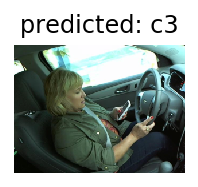

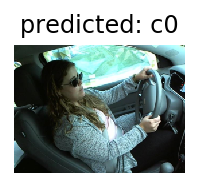

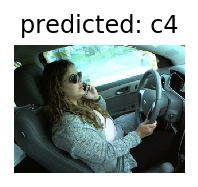

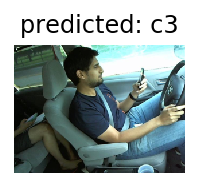

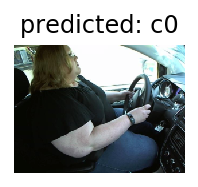

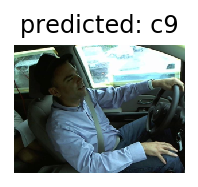

In [0]:
visualize_model(model)

# Loading the Checkpoint

In [0]:
def load_checkpoint(filepath):
    """ a function that loads a checkpoint and rebuilds the model """
    checkpoint = torch.load(filepath)
    model = models.resnet50()
    
    # our input_size matches the in_features of pretrained model
    input_size = 2048
    output_size = 10
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          #('dropout1', nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(512, 10)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))


    # replacing the pretrained model classifier with our classifier
    model.fc = classifier
    
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

# get index to class mapping
loaded_model, class_to_idx = load_checkpoint('/content/gdrive/My Drive/resnet50resize_best_wt_checkpoint.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

# Processing the Test Image

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model

    size = 361, 361
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    
    return npImage

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

# Prediction

In [0]:
def predict(image_path, model, topk=3, transform):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''

    image = transform(Image.open(image_path)).unsqueeze(0)
    model.eval()
    output = model.forward(Variable(image))
    probabilities = torch.exp(output).data.numpy()[0]
    

    top_idx = np.argsort(probabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = probabilities[top_idx]

    return top_idx , top_probability, top_class

In [0]:
top_classes_idx , top_probabilites , top_classes  = predict('valid/c1/img_10871.jpg', loaded_model , 3 , data_transforms['valid'])
print(top_classes_idx[0])

1


In [0]:
# Display an image along with the top 3 classes
def view_classify(img, probabilities, classes, mapper):
    ''' Function for viewing an image and it's predicted classes.
    '''
    img_filename = img.split('/')[-2]
    img = Image.open(img)

    fig, (ax1, ax2) = plt.subplots(figsize=(7,11), ncols=1, nrows=2) 
    driver_type = mapper[img_filename]
    
    ax1.set_title(driver_type)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in classes])
    ax2.invert_yaxis()

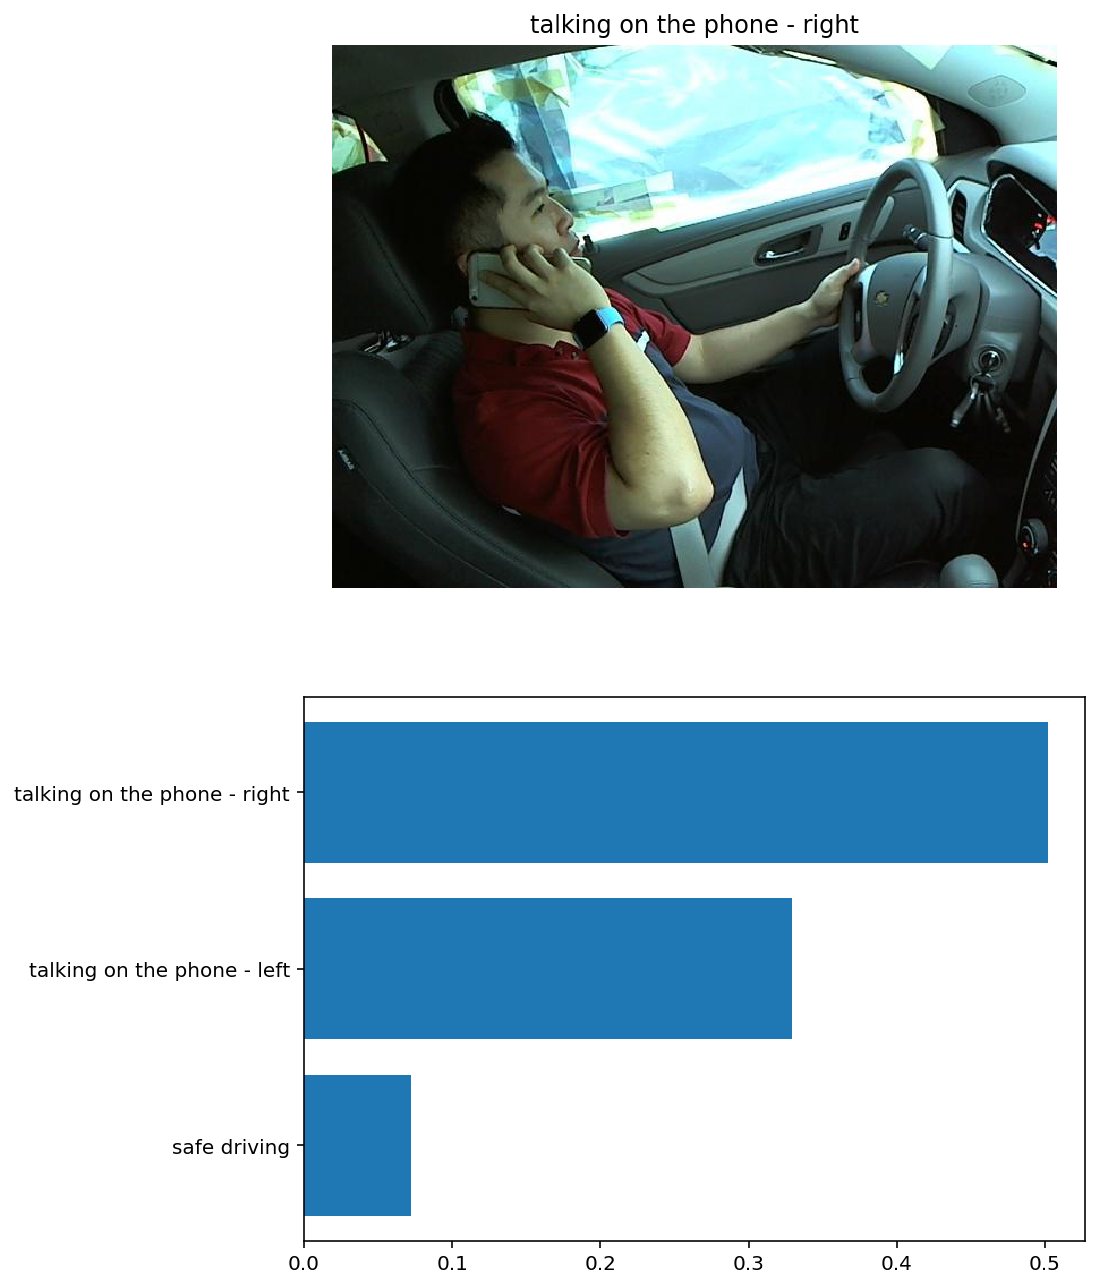

In [0]:
img ='valid/c2/img_13764.jpg'
_ , p, c = predict(img, loaded_model , 3 , data_transforms['valid'])
view_classify(img, p, c, cat_to_name)

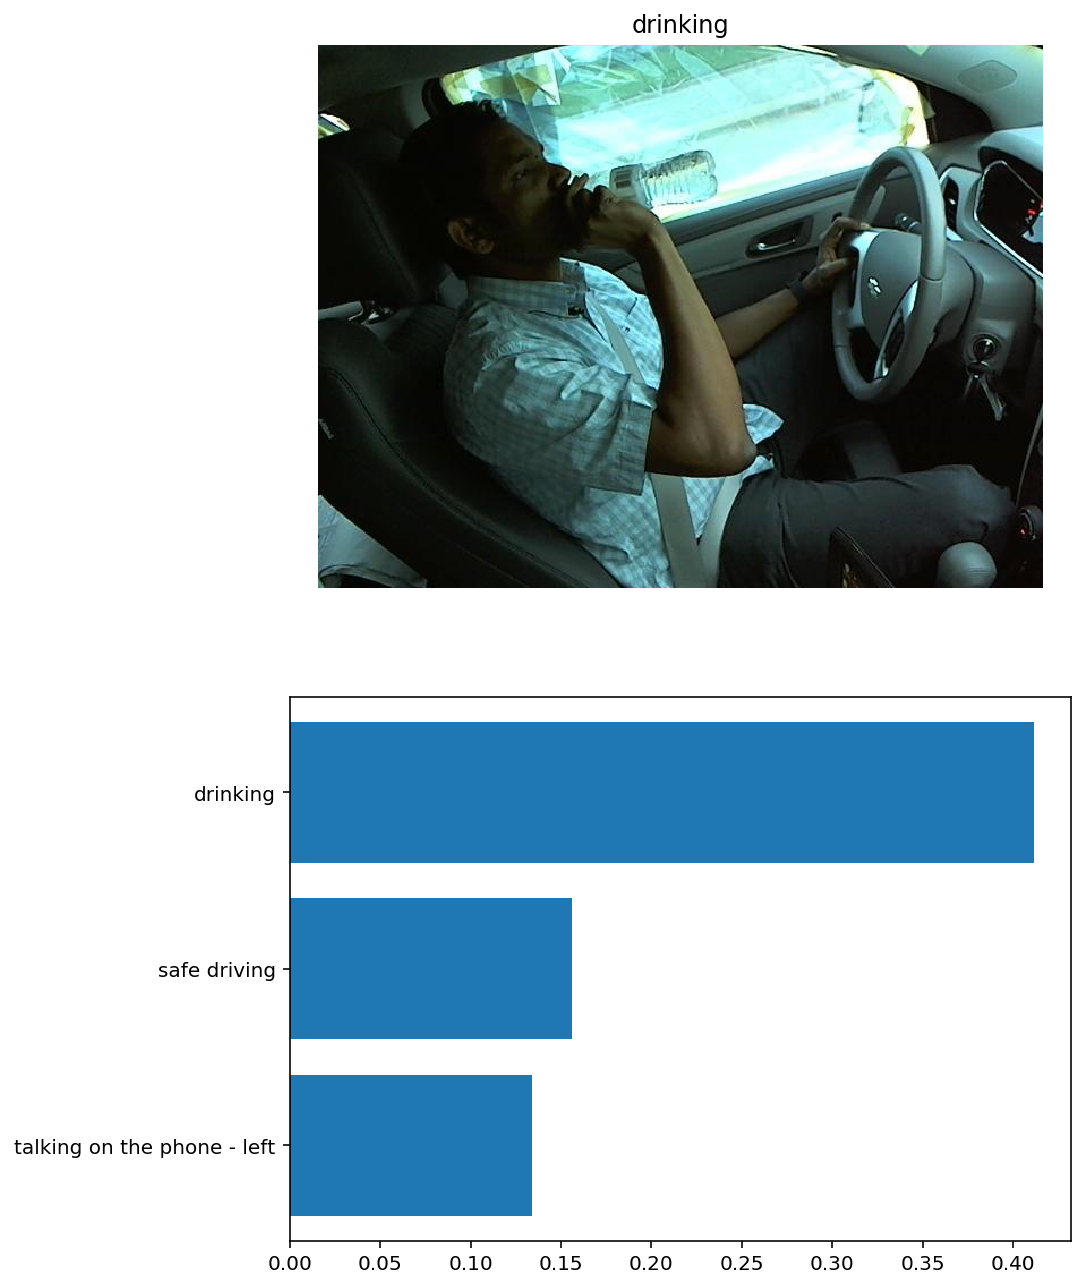

In [0]:
img ='valid/c6/img_101144.jpg'
_ , p, c = predict(img, loaded_model , 3 , data_transforms['valid'] )
view_classify(img, p, c, cat_to_name)

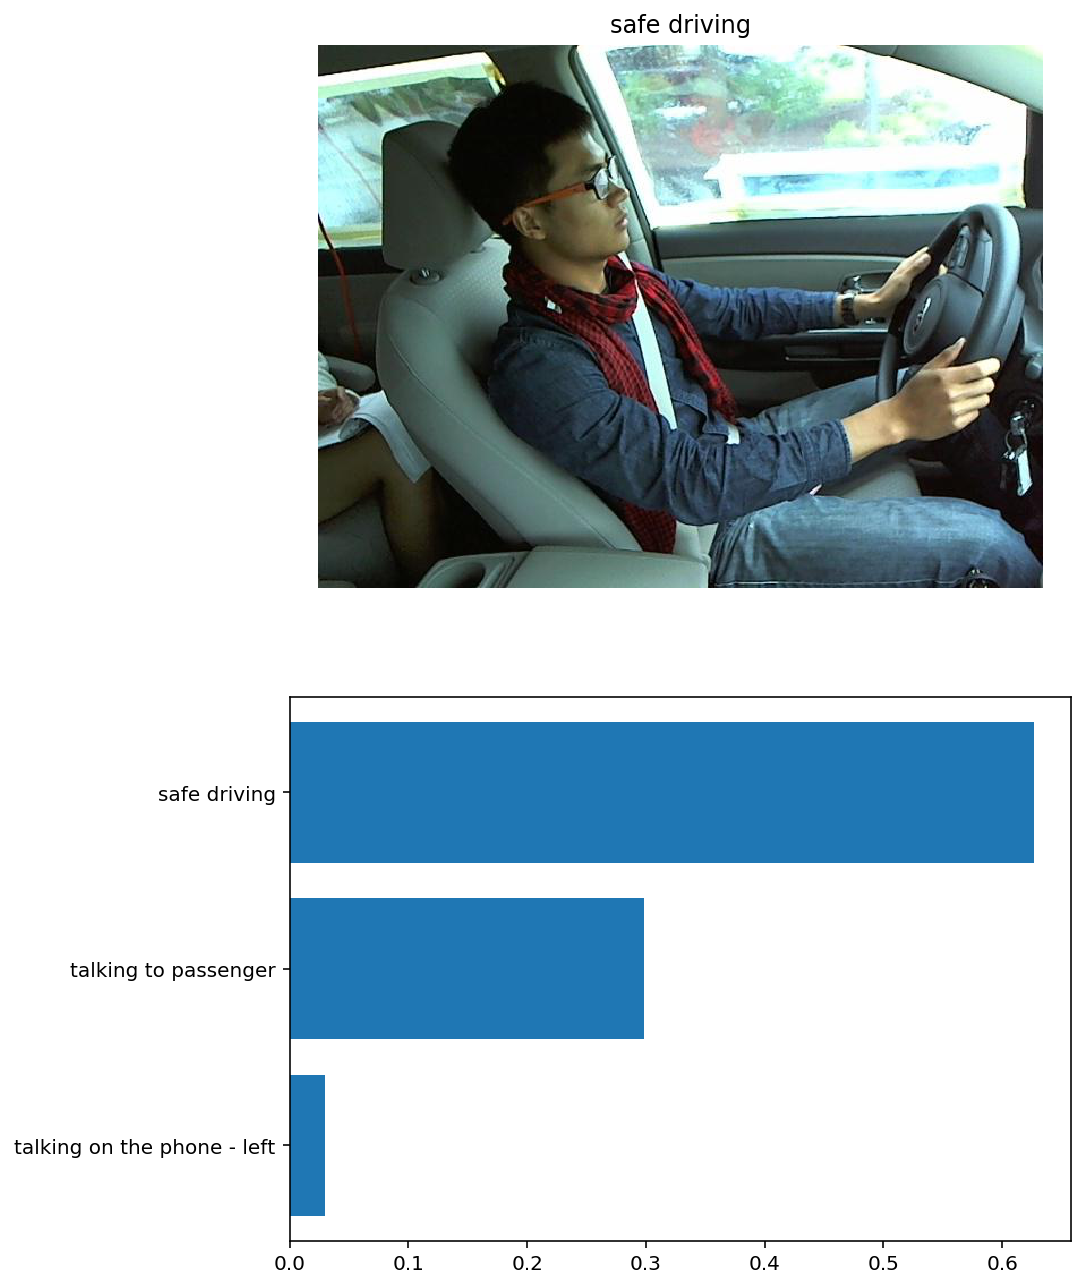

In [0]:
img ='valid/c0/img_1421.jpg'
_ , p, c = predict(img, loaded_model , 3 , data_transforms['valid'] )
view_classify(img, p, c, cat_to_name)

# Model Evaluation

In [0]:
# Do validation on the test set
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
    
  for images, labels in dataloaders['valid']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()
     
  print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['valid'])))

In [0]:
test(loaded_model, dataloaders, device)

Testing Accuracy: 0.880


In [0]:
y_pred = []
y_true = []

loaded_model.eval()
accuracy = 0

loaded_model.to(device)
  
for images, labels in dataloaders['valid']:
  images = Variable(images)
  labels = Variable(labels)
  images, labels = images.to(device), labels.to(device)
    
  output = loaded_model.forward(images)
  ps = torch.exp(output)
  pred = ps.max(1)[1]
  y_pred.extend(pred.cpu().numpy())
  y_true.extend(labels.cpu().numpy())
  
print(y_pred)
print(y_true)

[3, 3, 1, 4, 4, 5, 4, 3, 1, 8, 3, 7, 6, 2, 3, 2, 5, 1, 0, 9, 4, 2, 4, 8, 7, 0, 0, 8, 7, 9, 5, 5, 3, 1, 2, 3, 7, 7, 0, 9, 4, 6, 9, 9, 8, 1, 3, 9, 9, 3, 8, 2, 9, 9, 8, 3, 9, 8, 5, 1, 8, 0, 4, 5, 3, 0, 1, 3, 7, 7, 6, 1, 2, 6, 1, 0, 6, 5, 5, 8, 5, 8, 7, 7, 6, 3, 4, 9, 9, 5, 4, 1, 5, 0, 1, 3, 6, 9, 9, 2, 8, 0, 4, 5, 5, 3, 2, 3, 7, 5, 2, 0, 3, 7, 2, 0, 7, 1, 7, 5, 0, 0, 1, 5, 7, 8, 4, 9, 9, 3, 2, 9, 5, 4, 4, 5, 3, 0, 4, 3, 2, 7, 7, 0, 0, 8, 6, 0, 6, 4, 0, 2, 9, 3, 5, 5, 1, 3, 2, 7, 7, 5, 9, 6, 2, 6, 7, 4, 2, 4, 0, 0, 3, 2, 1, 4, 8, 1, 5, 3, 2, 3, 7, 8, 7, 7, 2, 9, 7, 2, 1, 4, 7, 6, 8, 4, 7, 4, 2, 1, 6, 7, 7, 6, 8, 2, 1, 7, 3, 1, 2, 3, 9, 9, 4, 8, 6, 0, 8, 5, 6, 0, 5, 3, 0, 4, 4, 0, 3, 2, 3, 3, 2, 7, 3, 6, 2, 1, 0, 4, 2, 0, 6, 9, 0, 6, 2, 6, 7, 4, 6, 3, 8, 0, 3, 1, 6, 1, 9, 1, 2, 3, 3, 2, 8, 6, 8, 2, 4, 0, 3, 6, 1, 2, 1, 7, 7, 3, 0, 8, 0, 8, 6, 0, 2, 6, 0, 0, 3, 2, 8, 2, 5, 2, 7, 0, 0, 8, 9, 5, 5, 9, 5, 1, 5, 2, 8, 5, 1, 7, 9, 2, 0, 7, 8, 2, 1, 2, 7, 0, 8, 5, 6, 0, 9, 8, 8, 1, 1, 9, 4, 9, 6, 

In [0]:
from sklearn.metrics import recall_score , f1_score ,precision_score
print(' recall is : ' , recall_score (y_true, y_pred, average='macro'))
print(' precision is : ' , precision_score(y_true, y_pred, average='macro'))
print(' f1 Score is : ' , f1_score(y_true, y_pred, average='macro') )

 recall is :  0.8800000000000001
 precision is :  0.8807526959532377
 f1 Score is :  0.8794921492503536


In [0]:
nb_classes = 10 
confusion_matrix = torch.zeros(nb_classes , nb_classes)
with torch.no_grad():
  for i , (inputs,classes) in enumerate(dataloaders['valid']):
    inputs = inputs.to(device) 
    classes = classes.to(device) 
    loaded_model.to(device)
    outputs = loaded_model(inputs)
    _ , preds = torch.max(outputs , 1 )
    for t,p in zip(classes.view(-1) , preds.view(-1)):
      confusion_matrix[t.long() , p.long()] +=1

print(confusion_matrix) 

tensor([[166.,   3.,   2.,   3.,   1.,   2.,   5.,   2.,   4.,  12.],
        [  4., 165.,   5.,   4.,   3.,   1.,  10.,   1.,   2.,   5.],
        [  0.,   0., 183.,   0.,   0.,   0.,   7.,   1.,   9.,   0.],
        [  9.,   1.,   0., 187.,   1.,   0.,   0.,   0.,   1.,   1.],
        [  3.,   0.,   5.,  15., 170.,   0.,   1.,   2.,   2.,   2.],
        [  4.,   0.,   1.,   2.,   0., 182.,   1.,   3.,   2.,   5.],
        [  1.,   6.,   9.,   1.,   0.,   0., 171.,   0.,  12.,   0.],
        [  2.,   0.,   1.,   0.,   0.,   1.,   3., 187.,   3.,   3.],
        [  4.,   5.,  11.,   2.,   4.,   2.,  11.,   5., 151.,   5.],
        [ 22.,   0.,   1.,   1.,   1.,   1.,   1.,   3.,   3., 167.]])


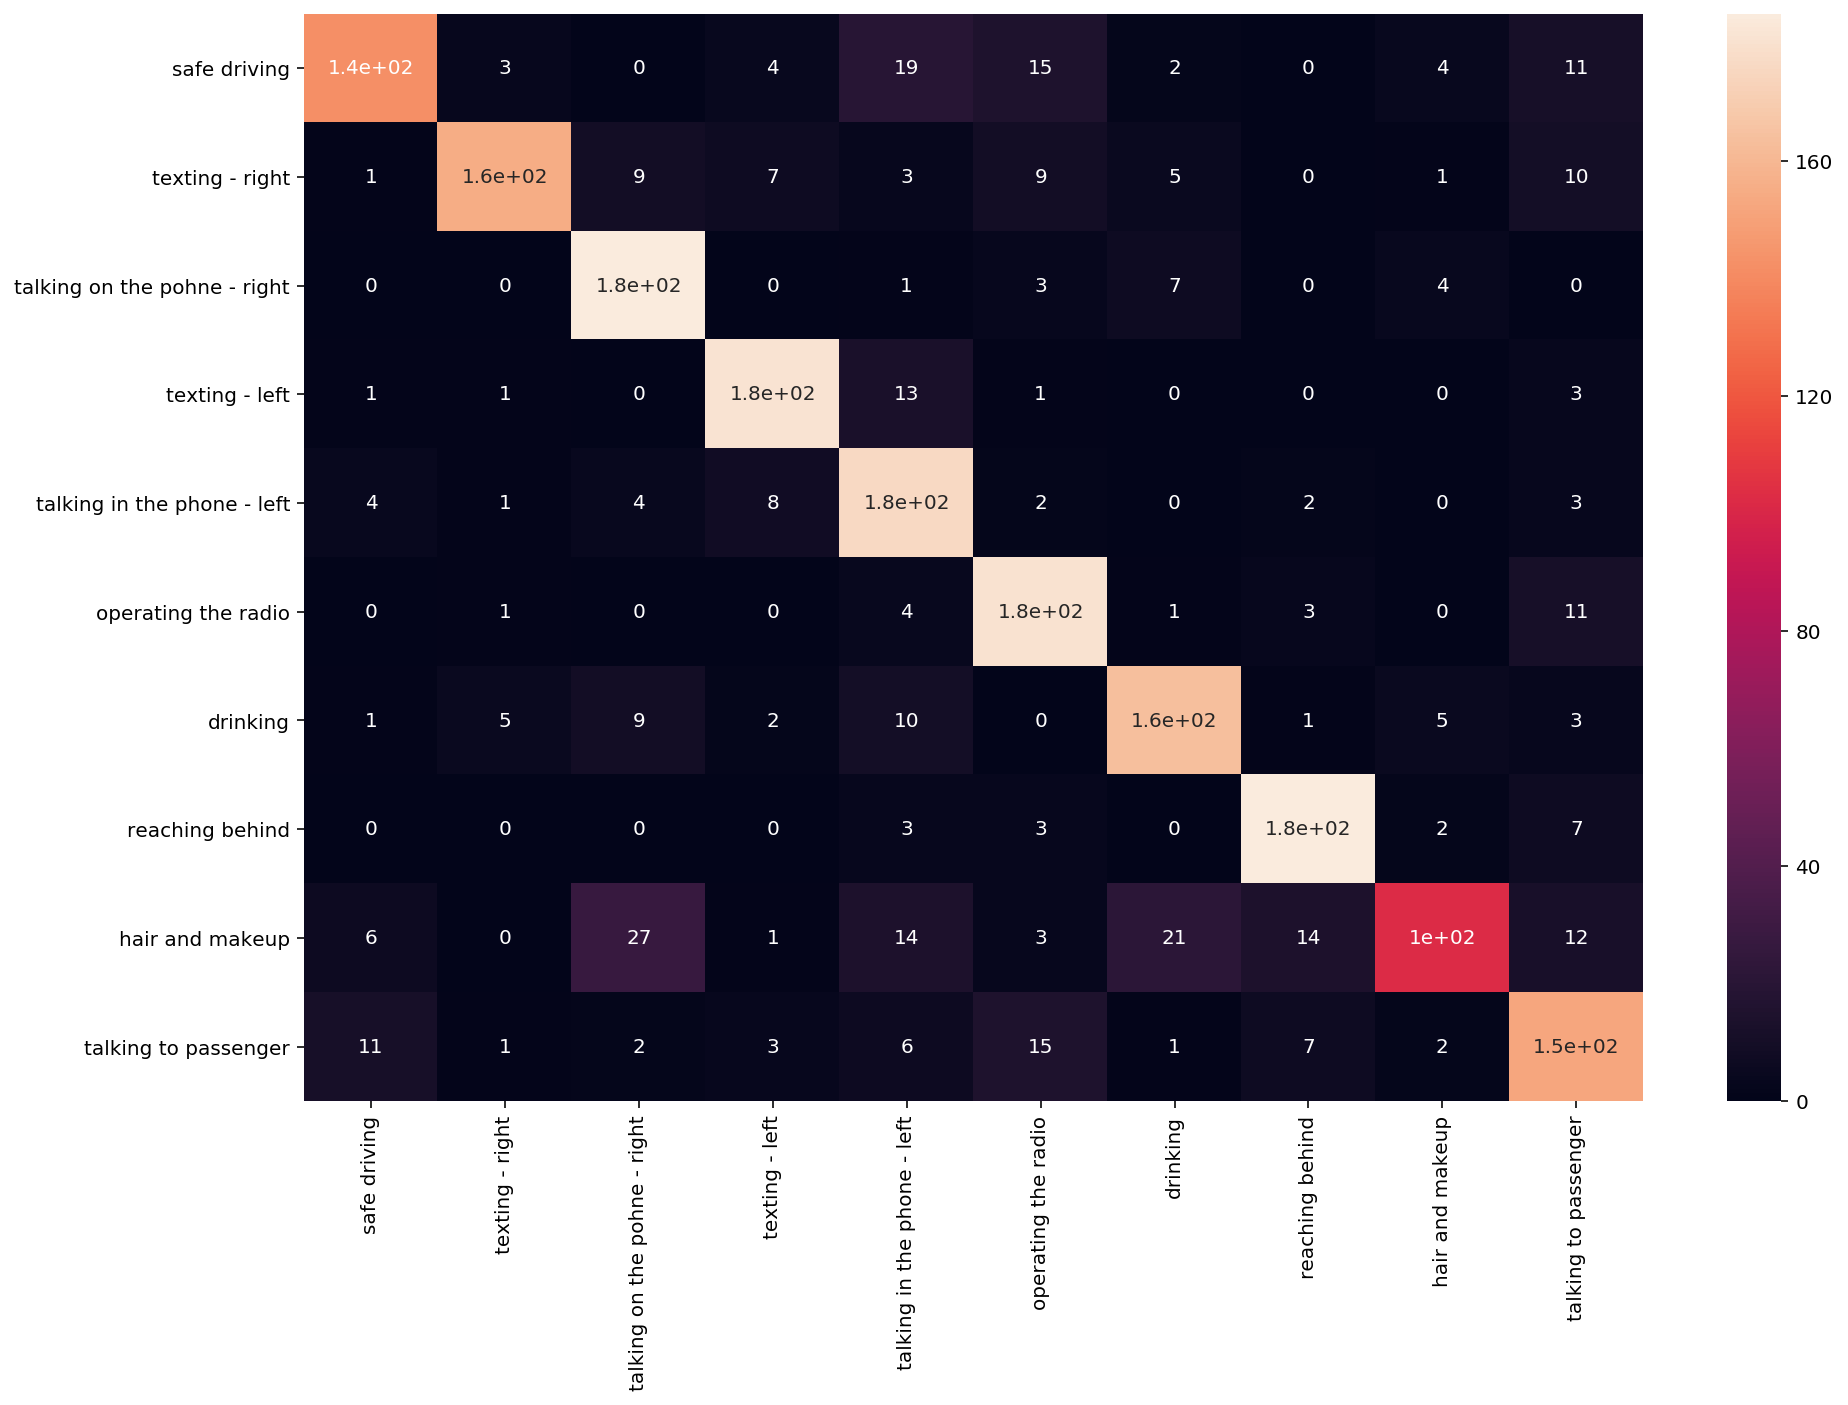

In [0]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confusion_matrix.cpu().numpy() 
df_cm = pd.DataFrame(array, index =  ['safe driving' , 'texting - right' , 'talking on the pohne - right' , 'texting - left' , 'talking in the phone - left' , 'operating the radio' , 'drinking' , 'reaching behind' ,'hair and makeup' ,'talking to passenger'],
                  columns = ['safe driving' , 'texting - right' , 'talking on the pohne - right' , 'texting - left' , 'talking in the phone - left' , 'operating the radio' , 'drinking' , 'reaching behind' ,'hair and makeup' ,'talking to passenger'])
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, annot=True)